This file contains the code which was used to select and time-shift data from Artemis for the two larger Artemis csv files.

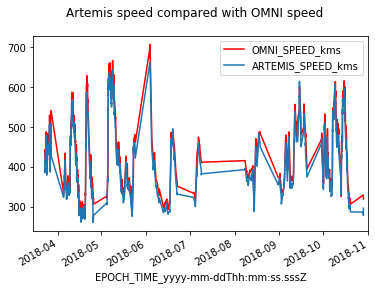

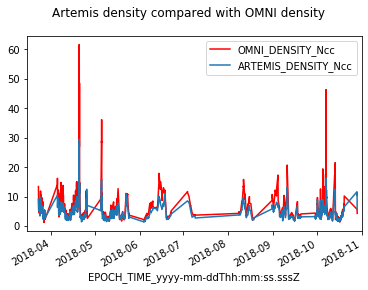

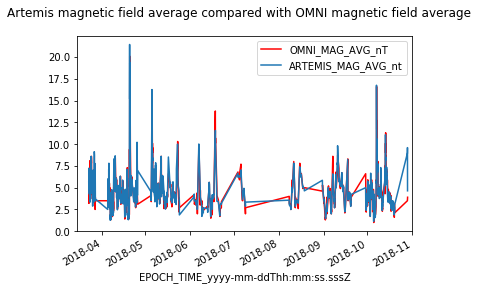

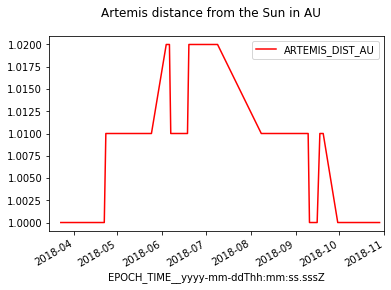

,OMNI_LAT_deg,OMNI_LONG_deg,OMNI_MAG_AVG_nT,OMNI_SPEED_kms,OMNI_DENSITY_Ncc,ARTEMIS_MAG_AVG_nt,ARTEMIS_DENSITY_Ncc,ARTEMIS_SPEED_kms,ARTEMIS_DIST_AU,ARTEMIS_LAT_DEG,ARTEMIS_LONG_DEG,Time_offset_hours
count,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.0
mean,-0.665862,191.169442,4.677186,432.790175,6.385429,4.767380,4.807994,414.629736,1.003905,-0.624979,191.907993,1.0
std,5.565974,75.389707,2.199109,93.832444,5.030637,2.279051,2.815542,91.839267,0.005522,5.524109,75.339063,0.0
min,-7.000000,105.200000,1.000000,272.000000,1.200000,1.137273,1.425000,260.983333,1.000000,-7.000000,106.300000,1.0
25%,-5.800000,127.300000,3.400000,357.000000,3.400000,3.395000,2.877308,340.750000,1.000000,-5.700000,128.300000,1.0
50%,-3.100000,155.200000,4.200000,418.000000,4.900000,4.257500,4.077143,398.657143,1.000000,-2.900000,156.400000,1.0
75%,6.100000,278.900000,5.400000,495.000000,8.100000,5.580769,5.981429,474.300000,1.010000,6.000000,279.900000,1.0
max,7.200000,318.500000,20.100000,707.000000,61.600000,21.435000,29.480000,663.155556,1.020000,7.200000,318.800000,1.0


In [38]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

posFrame = pd.read_csv('csv files/POS4Artemis1Year.csv')
windFrame = pd.read_csv('csv files/SW4Artemis1Year.csv')
windFrame = windFrame.loc[:, ~windFrame.columns.str.contains('^Unnamed')]
posFrame = posFrame.loc[:, ~posFrame.columns.str.contains('^Unnamed')]
windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
windFrame['date'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'])
posFrame['date'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
mergedFrame = pd.merge(windFrame, posFrame, on='date')
mergedFrame = mergedFrame.drop(['date', 'EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], axis=1)
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_MAG_AVG_nt != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_DENSITY_Ncc != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_SPEED_kms != -1.0E+31]

mergedFrame = mergedFrame[mergedFrame['GSE_X_RE'] >= -35]
mergedFrame = mergedFrame[mergedFrame['SSE_X_RM'] >= 0]
mergedFrame = mergedFrame[mergedFrame['ARTEMIS_DIST_AU'] >= 1]
mergedFrame = mergedFrame.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df2 = pd.read_csv('csv files/Omni4Artemis1Year.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['OMNI_MAG_AVG_nT'] != -1.0E+31]
df2 = df2[df2['OMNI_SPEED_kms'] != -1.0E+31]
df2 = df2[df2['OMNI_DENSITY_Ncc'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

mergedFrame = mergedFrame.drop(['GSE_X_RE', 'GSE_Y_RE', 'GSE_Z_RE', 'SSE_X_RM', 'SSE_Y_RM', 'SSE_Z_RM'], axis=1)
mergedFrame['new_time'] = mergedFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] - pd.Timedelta(hours = 1)
mergedFrame['Time_offset_hours'] = 1

mF = pd.merge(df2, mergedFrame, how='right', left_on='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', right_on='new_time')
mF = mF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)


fig1 = plt.figure(1)
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_SPEED_kms', color='red', ax=ax)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_SPEED_kms', ax=ax)
ax.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig2 = plt.figure(2)
fig2.suptitle("Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_DENSITY_Ncc', color='red', ax=ay)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_DENSITY_Ncc', ax=ay)
ay.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig3 = plt.figure(3)
fig3.suptitle("Artemis magnetic field average compared with OMNI magnetic field average")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_MAG_AVG_nT', color='red', ax=az)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_MAG_AVG_nt', ax=az)
az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig4 = plt.figure(4)
fig4.suptitle("Artemis distance from the Sun in AU")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_DIST_AU', color='red', ax=az)
az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

plt.show()

mF.describe()

#mF.to_csv('Artemis1Year.csv')

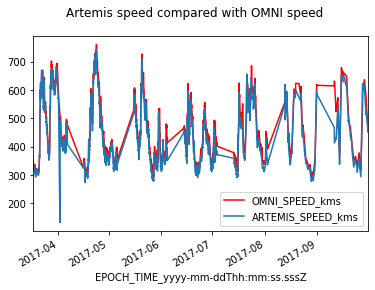

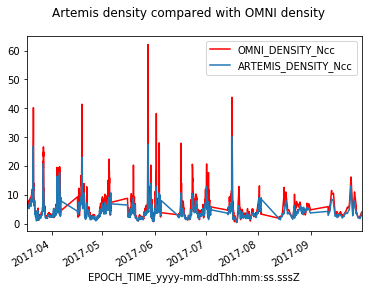

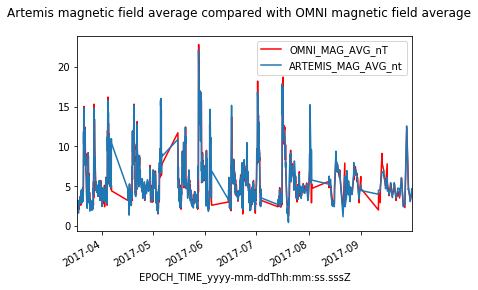

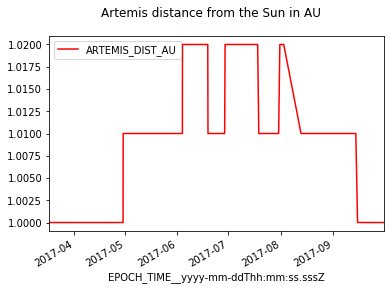

In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

posFrame = pd.read_csv('csv files/POS4Artemis1Year2.csv')
windFrame = pd.read_csv('csv files/SW4Artemis1Year2.csv')
windFrame = windFrame.loc[:, ~windFrame.columns.str.contains('^Unnamed')]
posFrame = posFrame.loc[:, ~posFrame.columns.str.contains('^Unnamed')]
windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
windFrame['date'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'])
posFrame['date'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
mergedFrame = pd.merge(windFrame, posFrame, on='date')
mergedFrame = mergedFrame.drop(['date', 'EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], axis=1)
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_MAG_AVG_nt != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_DENSITY_Ncc != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_SPEED_kms != -1.0E+31]

mergedFrame = mergedFrame[mergedFrame['GSE_X_RE'] >= -35]
mergedFrame = mergedFrame[mergedFrame['SSE_X_RM'] >= 0]
mergedFrame = mergedFrame[mergedFrame['ARTEMIS_DIST_AU'] >= 1]
mergedFrame = mergedFrame.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df2 = pd.read_csv('csv files/Omni4Artemis1Year2.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['OMNI_MAG_AVG_nT'] != -1.0E+31]
df2 = df2[df2['OMNI_SPEED_kms'] != -1.0E+31]
df2 = df2[df2['OMNI_DENSITY_Ncc'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

mergedFrame = mergedFrame.drop(['GSE_X_RE', 'GSE_Y_RE', 'GSE_Z_RE', 'SSE_X_RM', 'SSE_Y_RM', 'SSE_Z_RM'], axis=1)
mergedFrame['new_time'] = mergedFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] - pd.Timedelta(hours = 1)
mergedFrame['Time_offset_hours'] = 1

mF = pd.merge(df2, mergedFrame, how='right', left_on='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', right_on='new_time')
mF = mF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)


fig1 = plt.figure(1)
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_SPEED_kms', color='red', ax=ax)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_SPEED_kms', ax=ax)
#ax.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig2 = plt.figure(2)
fig2.suptitle("Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_DENSITY_Ncc', color='red', ax=ay)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_DENSITY_Ncc', ax=ay)
#ay.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig3 = plt.figure(3)
fig3.suptitle("Artemis magnetic field average compared with OMNI magnetic field average")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_MAG_AVG_nT', color='red', ax=az)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_MAG_AVG_nt', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig4 = plt.figure(4)
fig4.suptitle("Artemis distance from the Sun in AU")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_DIST_AU', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

plt.show()

mF.describe()

#mF.to_csv('Artemis1Year2.csv')